In [40]:
import pandas as pd
import numpy as np
import os
from glob import glob
from matplotlib import pyplot as plt

# Figures!

In [21]:
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2024-12-11_07-52-16-945389"
output_dir = os.path.join(base_dir, "outputs")
outputs_dirs = [os.path.join(output_dir, f"option_{i}") for i in range(6)]

In [22]:
collection_list_options = []

for opt in range(6):
    outputs = outputs_dirs[opt]
    if not os.path.exists(outputs):
        continue
    collection_list = []

    # for each arr, store a 2D array in the list
    # axis = 0 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)
    # axis = 1 are the years 2016, 2021, 2026, 2031, 2051
    for i,f in enumerate(sorted(glob(outputs + "/*.npy"))):
        """ 
        The shape of each of these arrays is (51,2,2,2,6)
        The index on each axis corresponds to year, black, pov, plus65, smoking state
        And the array element at that location is the weighted count.
        (These are numpy outputs from the simulation)
        """
        arr = np.load(f)
        arr = arr[:,:,:,0,:] # age-restrict 18-64
        arr = arr[:-5] # get the years we are interested in
        arr = arr[:,:,:,:-1] # don't need dead people (smoking state 6)
        arr = arr.transpose((3,1,2,0)) # transpose so we have (smoking states, black, pov, years) as axes
        arr = np.concatenate([ # want to add the smokers together too
            arr[0:4],
            (arr[2] + arr[3])[np.newaxis, :],
            arr[4][np.newaxis, :],
        ], axis=0)
        arr = arr[[2,3,4,5,1,0]] # re-order the smoking groups to be menthol, nonmenthol, menthol+nonmenthol, ecig/dual, former, nonsmoker
        # add change 2016-2031 column and change from SQ column
        collection_list.append(arr)

    collection_list_options.append(collection_list)

collection_list_options = np.array(collection_list_options)

In [23]:
"""
The axes here are ban option #, output #, smoking state, black, pov, year
with the smoking states being menthol, nonmenthol, menthol+nonmenthol, ecig/dual, former, nonsmoker
"""
print(collection_list_options.shape)

# print the total population by year for option 0
# arr = collection_list_options[0,0]
# arr = np.sum(arr, axis=(0,1,2))
# for i in range(len(arr)):
#     print(str(2016+i) + " " + str(arr[i]))

(6, 27, 6, 2, 2, 96)


## grab BRFSS and NHIS data

In [24]:
# BRFSS data
file = os.path.join("..", "..", "nhis_data", "BRFSSNHIS_Jiaqian.xlsx")

# US population
BRFSS_data = np.concatenate([
    pd.read_excel(file).to_numpy()[5,1::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[5,2::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[5,3::9][:,np.newaxis],
], axis=1)[[0,1,5]]
BRFSS_data = np.concatenate([
    np.array([
        [2016.],
        [2017.],
        [2021.],
    ]),
    BRFSS_data,
], axis=1)
BRFSS_x = BRFSS_data[:,0]
BRFSS_y = BRFSS_data[:,1]
BRFSS_e = BRFSS_data[:,3] - BRFSS_data[:,2]
BRFSS_e /= 2

# Black population
BRFSS_data_black = np.concatenate([
    pd.read_excel(file).to_numpy()[10,1::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[10,2::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[10,3::9][:,np.newaxis],
], axis=1)[[0,1,5]]
BRFSS_data_black = np.concatenate([
    np.array([
        [2016.],
        [2017.],
        [2021.],
    ]),
    BRFSS_data_black,
], axis=1)
BRFSS_x_black = BRFSS_data_black[:,0]
BRFSS_y_black = BRFSS_data_black[:,1]
BRFSS_e_black = BRFSS_data_black[:,3] - BRFSS_data_black[:,2]
BRFSS_e_black /= 2

# Nonblack population
BRFSS_data_nonblack = np.concatenate([
    pd.read_excel(file).to_numpy()[15,1::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[15,2::9][:,np.newaxis],
    pd.read_excel(file).to_numpy()[15,3::9][:,np.newaxis],
], axis=1)[[0,1,5]]
BRFSS_data_nonblack = np.concatenate([
    np.array([
        [2016.],
        [2017.],
        [2021.],
    ]),
    BRFSS_data_nonblack,
], axis=1)
BRFSS_x_nonblack = BRFSS_data_nonblack[:,0]
BRFSS_y_nonblack = BRFSS_data_nonblack[:,1]
BRFSS_e_nonblack = BRFSS_data_nonblack[:,3] - BRFSS_data_nonblack[:,2]
BRFSS_e_nonblack /= 2


In [25]:
NHIS_file = os.path.join("../../nhis_data/NHIS_state_Jiaqian_Oct2023.xlsx")

def add_error_column(arr):
    return np.concatenate([
        arr,
        (arr[:,2] - arr[:,1]).reshape((-1,1))/2
    ], axis=1)

NHIS_smoking_prevalence_18_64_all = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_All_18-64").to_numpy()[2::6,3:6])
# print("all")
# print(NHIS_smoking_prevalence_18_64_all)
NHIS_smoking_prevalence_18_64_black = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_NH Black_18-64").to_numpy()[2::6,3:6])
# print("black")
# print(NHIS_smoking_prevalence_18_64_black)
NHIS_smoking_prevalence_18_64_nonblack = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_All other races_18-64").to_numpy()[2::6,3:6])
# print("nonblack")
# print(NHIS_smoking_prevalence_18_64_nonblack )
NHIS_smoking_prevalence_18_64_pov = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_Poverty_18-64").to_numpy()[2::6,3:6])
# print("pov")
print(NHIS_smoking_prevalence_18_64_pov )
NHIS_smoking_prevalence_18_64_nonpov = add_error_column(pd.read_excel(NHIS_file, sheet_name="NHIS_Above FPL_18-64").to_numpy()[2::6,3:6])
# print("nonpov")
# print(NHIS_smoking_prevalence_18_64_nonpov )

NHIS_x = np.array([2016, 2017, 2018, 2019, 2020, 2021])

[[24.0953378050436 22.30439931398652 25.88627629610068 1.79093849105708]
 [21.83177881015995 19.941146262043386 23.722411358276513
  1.8906325481165638]
 [22.1972912 20.22356098 24.17102142 1.9737302200000002]
 [21.8763 19.9503 23.8023 1.9260000000000002]
 [21.914 19.6174 24.2106 2.2965999999999998]
 [19.6017 17.6487 21.5548 1.9530499999999993]]


## Now looking at cigarette smoking over time, status quo scenario, and by demographic groups

[15.1316     14.58966891 13.79807436 13.08375737 12.4396338  11.87323782
 11.40844208 11.01968169 10.69214003 10.41767652 10.24350153  9.98434066
  9.87519748  9.72818979  9.60731502  9.53535842  9.45071059  9.3865931
  9.34408045  9.32908891  9.25530982  9.24184547  9.22068727  9.15551852
  9.13124648  9.13081552  9.07394827  9.04208126  9.00713744  8.991937
  8.9376851   8.87632231  8.82154012  8.77904354  8.7109793   8.66518911
  8.62284644  8.56768228  8.53007108  8.45913243  8.4384594   8.35344819
  8.32128109  8.23487932  8.17828583  8.11075869  8.09828964  8.10353587
  8.09244214  8.09672301  8.08577276  8.10793843  8.09747294  8.12084269
  8.12967378  8.13281282  8.12725231  8.11446784  8.14600524  8.11971396
  8.12607883  8.13646797  8.14137068  8.1409811   8.13881071  8.12738347
  8.12512899  8.13886605  8.11253788  8.13075728  8.13902772  8.13350102
  8.13688778  8.13486151  8.12956329  8.11316432  8.11977182  8.11330308
  8.12306367  8.13075384  8.14129598  8.12749186  8.11

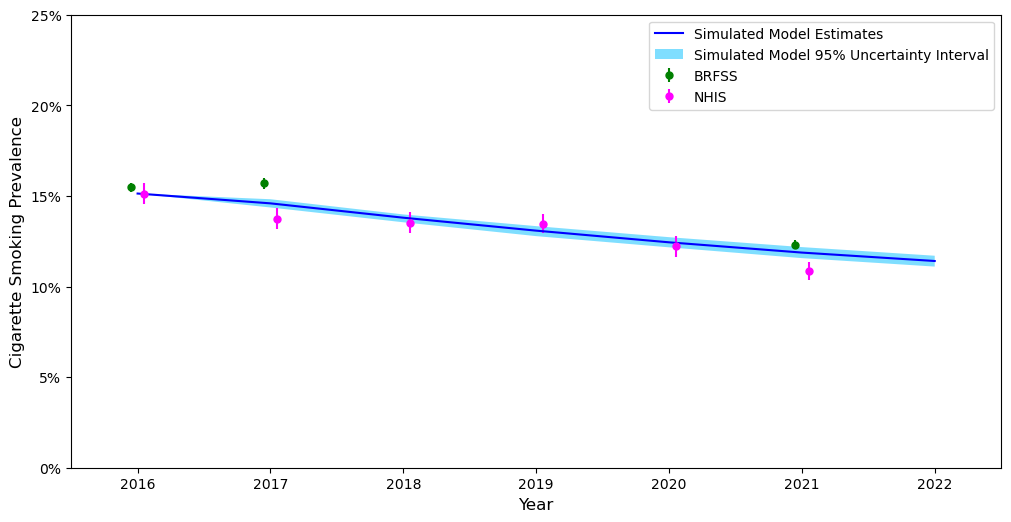

In [26]:

year_limit = 7 # limit years to 2022
opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2062)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(2,3)) # combine all demographics
# dims:  output #, smoking status, year; shape (125, 6, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :] # change from absolute counts to proportion of total
to_plot = to_plot[:,2,:] # only want menthol + nonmenthol
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

print(mean)

ax.plot(x[:year_limit], mean[:year_limit], "blue")
ax.fill_between(x[:year_limit], lower[:year_limit], upper[:year_limit], facecolor='deepskyblue', alpha=0.5)
ax.errorbar(BRFSS_x - 0.05, BRFSS_y, yerr=BRFSS_e, fmt='o', ms=5, color="green")
ax.errorbar(NHIS_x + 0.05, NHIS_smoking_prevalence_18_64_all[:,0], NHIS_smoking_prevalence_18_64_all[:,3], fmt='o', ms=5, color="magenta")

plt.ylim(0,25)
plt.xlim(x[:year_limit][0]-0.5, x[:year_limit][-1]+0.5)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cigarette Smoking Prevalence", fontsize=12)
plt.xticks(x[:year_limit][::1], fontsize=10, horizontalalignment='center')
# plt.yticks(np.arange(0,25)[::2], fontsize=10, horizontalalignment='center')
y_tick_nums = np.arange(0,25 + 1,5) # plus one because arange doesn't include the "stop" param
y_tick_labels = [str(x) + "%" for x in y_tick_nums]
plt.yticks(y_tick_nums, y_tick_labels)
plt.legend([ 
    f"Simulated Model Estimates",
    f"Simulated Model 95% Uncertainty Interval",
    f"BRFSS",
    f"NHIS",
])

plt.show()





[15.1316     14.58966891 13.79807436 13.08375737 12.4396338  11.87323782
 11.40844208 11.01968169 10.69214003 10.41767652 10.24350153  9.98434066
  9.87519748  9.72818979  9.60731502  9.53535842  9.45071059  9.3865931
  9.34408045  9.32908891  9.25530982  9.24184547  9.22068727  9.15551852
  9.13124648  9.13081552  9.07394827  9.04208126  9.00713744  8.991937
  8.9376851   8.87632231  8.82154012  8.77904354  8.7109793   8.66518911
  8.62284644  8.56768228  8.53007108  8.45913243  8.4384594   8.35344819
  8.32128109  8.23487932  8.17828583  8.11075869  8.09828964  8.10353587
  8.09244214  8.09672301  8.08577276  8.10793843  8.09747294  8.12084269
  8.12967378  8.13281282  8.12725231  8.11446784  8.14600524  8.11971396
  8.12607883  8.13646797  8.14137068  8.1409811   8.13881071  8.12738347
  8.12512899  8.13886605  8.11253788  8.13075728  8.13902772  8.13350102
  8.13688778  8.13486151  8.12956329  8.11316432  8.11977182  8.11330308
  8.12306367  8.13075384  8.14129598  8.12749186  8.11

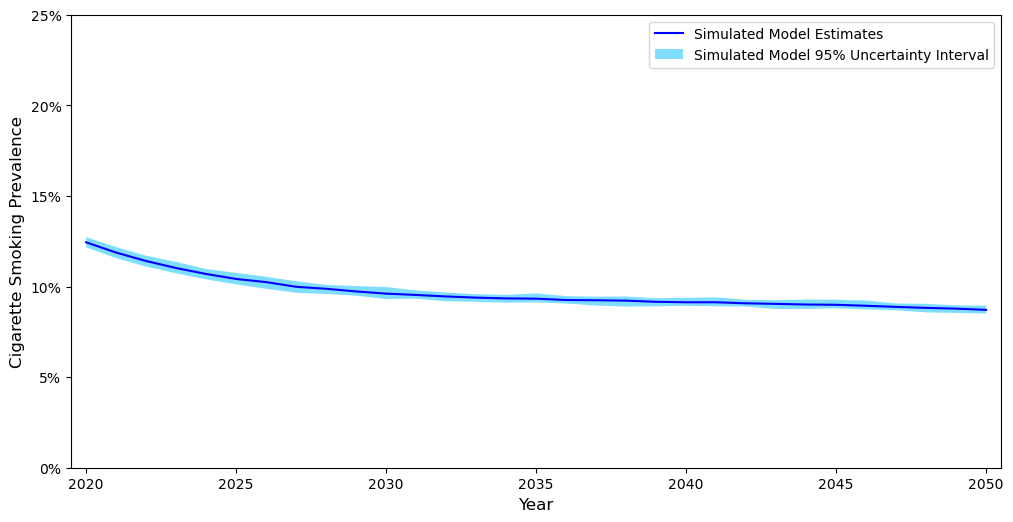

In [27]:
# Same Status Quo Data but different formatting

year_limit = 35 # limit years
opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2062)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(2,3)) # combine all demographics
# dims:  output #, smoking status, year; shape (125, 6, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :] # change from absolute counts to proportion of total
to_plot = to_plot[:,2,:] # only want menthol + nonmenthol
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

print(mean)

ax.plot(x[4:year_limit], mean[4:year_limit], "blue")
ax.fill_between(x[4:year_limit], lower[4:year_limit], upper[4:year_limit], facecolor='deepskyblue', alpha=0.5)
# ax.errorbar(BRFSS_x - 0.05, BRFSS_y, yerr=BRFSS_e, fmt='o', ms=5, color="green")
# ax.errorbar(NHIS_x + 0.05, NHIS_smoking_prevalence_18_64_all[:,0], NHIS_smoking_prevalence_18_64_all[:,3], fmt='o', ms=5, color="magenta")

plt.ylim(0,25)
plt.xlim(x[:year_limit][4]-0.5, x[:year_limit][-1]+0.5)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cigarette Smoking Prevalence", fontsize=12)
plt.xticks(x[:year_limit][4::5], fontsize=10, horizontalalignment='center')
# plt.yticks(np.arange(0,25)[::2], fontsize=10, horizontalalignment='center')
y_tick_nums = np.arange(0,25 + 1,5) # plus one because arange doesn't include the "stop" param
y_tick_labels = [str(x) + "%" for x in y_tick_nums]
plt.yticks(y_tick_nums, y_tick_labels)
plt.legend([ 
    f"Simulated Model Estimates",
    f"Simulated Model 95% Uncertainty Interval",
    # f"BRFSS",
    # f"NHIS",
])

plt.show()

In [28]:
mean[4:year_limit]

array([12.4396338 , 11.87323782, 11.40844208, 11.01968169, 10.69214003,
       10.41767652, 10.24350153,  9.98434066,  9.87519748,  9.72818979,
        9.60731502,  9.53535842,  9.45071059,  9.3865931 ,  9.34408045,
        9.32908891,  9.25530982,  9.24184547,  9.22068727,  9.15551852,
        9.13124648,  9.13081552,  9.07394827,  9.04208126,  9.00713744,
        8.991937  ,  8.9376851 ,  8.87632231,  8.82154012,  8.77904354,
        8.7109793 ])

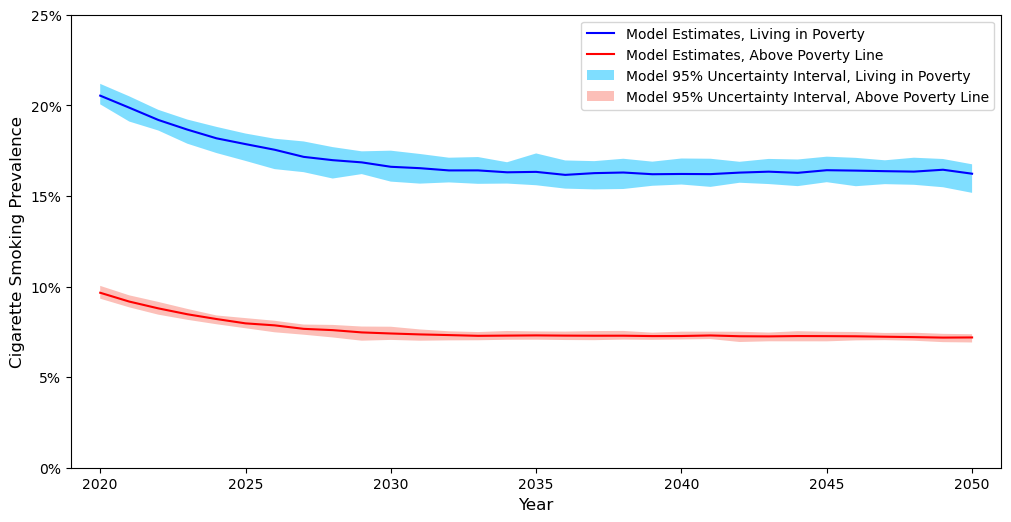

'blah'

In [29]:
# Cigarette Smokers over time, stratified by poverty status, status quo scenario

opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

year_limit = 35 # limit years to 2022
x = np.arange(2016,2062)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(2)) # sum over black
# dims:  output #, smoking status, pov, year; shape (125, 6, 2, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :, :] # change from absolute counts to proportion of total
to_plot = to_plot[:,2,:,:] # only want menthol + nonmenthol
to_plot *= 100
to_plot = to_plot[:,:,:year_limit]

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

# poverty
ax.plot(x[4:year_limit], mean[1][4:year_limit], "blue")
ax.fill_between(x[4:year_limit], lower[1][4:year_limit], upper[1][4:year_limit], facecolor='deepskyblue', alpha=0.5)

# no poverty
ax.plot(x[4:year_limit], mean[0][4:year_limit], "red")
ax.fill_between(x[4:year_limit], lower[0][4:year_limit], upper[0][4:year_limit], facecolor='salmon', alpha=0.5)

# ax.errorbar(NHIS_x, NHIS_smoking_prevalence_18_64_pov[:,0], NHIS_smoking_prevalence_18_64_pov[:,3], fmt='o', ms=5, color="magenta")
# ax.errorbar(NHIS_x, NHIS_smoking_prevalence_18_64_nonpov[:,0], NHIS_smoking_prevalence_18_64_nonpov[:,3], fmt='o', ms=5, color="green")

plt.ylim(0,25)
plt.xlim(2019, 2051)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cigarette Smoking Prevalence", fontsize=12)
plt.xticks(x[4:36:5], fontsize=10, horizontalalignment='center')
y_tick_nums = np.arange(0,25 + 1,5) # plus one because arange doesn't include the "stop" param
y_tick_labels = [str(x) + "%" for x in y_tick_nums]
plt.yticks(y_tick_nums, y_tick_labels)
plt.legend([ 
    f"Model Estimates, Living in Poverty",
    f"Model Estimates, Above Poverty Line",
    f"Model 95% Uncertainty Interval, Living in Poverty",
    f"Model 95% Uncertainty Interval, Above Poverty Line",
    # f"NHIS Estimates, Living in Poverty",
    # f"NHIS Estimates, Above Poverty Line",
])

plt.show()

"blah"


[[14.69829985 14.21951999 13.39739706 12.66256165 12.00197722 11.43166891
  10.96480116]
 [18.29857638 17.27927112 16.69671591 16.13185295 15.59533662 15.0545612
  14.60689801]]


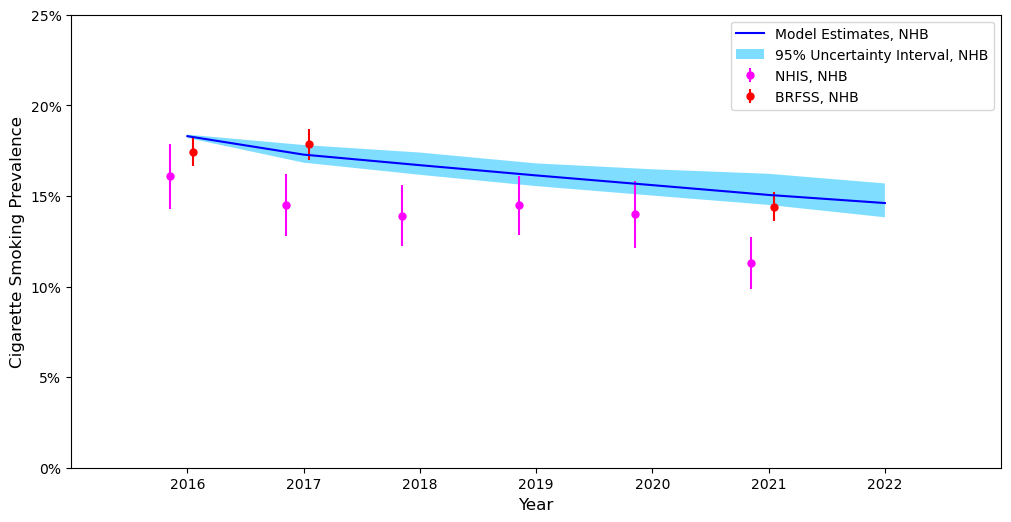

In [30]:
# Cigarette Smokers over time, stratified by race, status quo scenario
opt = 0

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2023)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(3)) # sum over pov
# dims:  output #, smoking status, pov, year; shape (125, 6, 2, 16)
"""
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :, :] # change from absolute counts to proportion of total
to_plot = to_plot[:,2,:,:] # only want menthol + nonmenthol
to_plot *= 100
to_plot = to_plot[:,:,:len(x)]

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

print(mean)

# black
ax.plot(x, mean[1], "blue")
ax.fill_between(x, lower[1], upper[1], facecolor='deepskyblue', alpha=0.5)

# non black
# ax.plot(x, mean[0], "red")
# ax.fill_between(x, lower[0], upper[0], facecolor='salmon', alpha=0.5)

ax.errorbar(NHIS_x-0.15, NHIS_smoking_prevalence_18_64_black[:,0], NHIS_smoking_prevalence_18_64_black[:,3], fmt='o', ms=5, color="magenta")
# ax.errorbar(NHIS_x-0.05, NHIS_smoking_prevalence_18_64_nonblack[:,0], NHIS_smoking_prevalence_18_64_nonblack[:,3], fmt='o', ms=5, color="green")

ax.errorbar(BRFSS_x_black+0.05, BRFSS_y_black, yerr=BRFSS_e_black, fmt='o', ms=5, color="red")
# ax.errorbar(BRFSS_x_nonblack+0.15, BRFSS_y_nonblack, yerr=BRFSS_e_nonblack, fmt='o', ms=5, color="orange")

plt.ylim(5,25)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Cigarette Smoking Prevalence", fontsize=12)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
y_tick_nums = np.arange(0,25 + 1,5) # plus one because arange doesn't include the "stop" param
y_tick_labels = [str(x) + "%" for x in y_tick_nums]
plt.yticks(y_tick_nums, y_tick_labels)
plt.legend([ 
    f"Model Estimates, NHB",
    f"95% Uncertainty Interval, NHB",
    # f"Smoking Prevalence, All Other",
    # f"Simulated Model 95% Uncertainty Interval, All Other",
    f"NHIS, NHB",
    # f"NHIS Estimates, All Other",
    f"BRFSS, NHB",
    # f"BRFSS Estimates, All Other",
])


In [31]:

"""
opt = 1
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

to_plot = np.copy(collection_list_options[opt, :, 2, :])
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean_SQ, "blue")
ax.fill_between(x, lower_SQ, upper_SQ, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.plot(x, mean, "red")
ax.fill_between(x, lower, upper, facecolor='tomato', alpha=0.5, label='_nolegend_')
ax.axvline(2021, ymin=0.1, ymax=0.9, color='k', linestyle='dashed')

ax.text(2031.1, mean_SQ[-1], f"{np.around(mean_SQ[-1], decimals=1)}%", c='k')
ax.text(2031.1, mean[-1], f"{np.around(mean[-1], decimals=1)}%", c='k')

plt.ylim(5,18)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
plt.legend([ 
    f"Cigarette smoking prevalence, status quo scenario",
    f"Cigarette smoking prevalence, ban option={opt}",
])

plt.show()
"""

'\nopt = 1\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\nto_plot = np.copy(collection_list_options[opt, :, 2, :])\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean_SQ, "blue")\nax.fill_between(x, lower_SQ, upper_SQ, facecolor=\'deepskyblue\', alpha=0.5, label=\'_nolegend_\')\nax.plot(x, mean, "red")\nax.fill_between(x, lower, upper, facecolor=\'tomato\', alpha=0.5, label=\'_nolegend_\')\nax.axvline(2021, ymin=0.1, ymax=0.9, color=\'k\', linestyle=\'dashed\')\n\nax.text(2031.1, mean_SQ[-1], f"{np.around(mean_SQ[-1], decimals=1)}%", c=\'k\')\nax.text(2031.1, mean[-1], f"{np.around(mean[-1], decimals=1)}%", c=\'k\')\n\nplt.ylim(5,18)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Cigarette Sm

In [32]:
# NSDUH Data (2016-2020)

NSDUH_all = np.array([39.17, 40.11, 40.98, 42.04, 43.51])
NSDUH_black = np.array([87.36, 82.75, 86.39, 85.96, 80.42])
NSDUH_pov = np.array([45.39, 47.01, 47.54, 52.64, 52.83])

In [33]:
# Menthol users among all smokers
"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_all, c='red')

plt.ylim(35,61)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Smokers", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])
"""

'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,:2,:,:,:]\nto_plot = np.sum(to_plot, axis=(3,4))\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label="_nolegend_")\nax.scatter(np.arange(2016,2021), NSDUH_all, c=\'red\')\n\nplt.ylim(35,61)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Menthol Cigarette Use Among Smokers", fontsize=16)\nplt.legend([ \n    f"simulated menthol prevalence",\n    f"NSDUH estimates of methol prevalence",\

In [34]:

# Menthol users among black smokers
"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=4)[:,:,:,1]
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_black, c='red')

plt.ylim(75, 95)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Black Non-Hispanic Smokers", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])
"""

'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,:2,:,:,:]\nto_plot = np.sum(to_plot, axis=4)[:,:,:,1]\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label="_nolegend_")\nax.scatter(np.arange(2016,2021), NSDUH_black, c=\'red\')\n\nplt.ylim(75, 95)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Menthol Cigarette Use Among Black Non-Hispanic Smokers", fontsize=16)\nplt.legend([ \n    f"simulated menthol prevalence",\n    f"NSDUH estima

In [35]:

# Menthol users among pov smokers

"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=3)[:,:,:,1]
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_pov, c='red')

plt.ylim(44, 68)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Smokers Living in Poverty", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])
"""

'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2016,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,:2,:,:,:]\nto_plot = np.sum(to_plot, axis=3)[:,:,:,1]\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label="_nolegend_")\nax.scatter(np.arange(2016,2021), NSDUH_pov, c=\'red\')\n\nplt.ylim(44, 68)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Menthol Cigarette Use Among Smokers Living in Poverty", fontsize=16)\nplt.legend([ \n    f"simulated menthol prevalence",\n    f"NSDUH estimates

In [36]:
# Looking at old people just for fun

"""
output_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data_4-25-2023_longleaf_partial/option_0"

collection_list = []

# for each arr, store a 2D array in the list
# axis = 0 will be the iteration
# axis = 1 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)
# axis = 2 will be the years 2016-2031
# axis = 3 will be black
# axis = 4 will be pov
for i,f in enumerate(sorted(glob(output_dir + "/*.npy"))):
    arr = np.load(f)
    # shape at this point is year, black, pov, plus65, smoking_state
    arr = arr[1:16] # get the years we are interested in
    arr = arr[:, :, :, 1, :] # remove people 65 and over
    arr = arr[:, :, :, :-1] # don't need dead people
    # sums = np.sum(arr, axis=(1,2,3)) # total count for each year
    # arr = arr / sums[:, np.newaxis, np.newaxis, np.newaxis] # get proportions
    arr = np.transpose(arr, axes=(3,0,1,2)) # transpose so we have (smoking groups, years, black, pov) as axes
    arr = np.concatenate([ # want to add the smokers together too
        arr[0:4],
        (arr[2] + arr[3])[np.newaxis, :,:,:],
        arr[4][np.newaxis, :,:,:],
    ], axis=0)
    arr = arr[[2,3,4,5,1,0]] # re-order the smoking groups

    collection_list.append(arr)

SQ_output_arr = np.array(collection_list)
"""

'\noutput_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data_4-25-2023_longleaf_partial/option_0"\n\ncollection_list = []\n\n# for each arr, store a 2D array in the list\n# axis = 0 will be the iteration\n# axis = 1 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)\n# axis = 2 will be the years 2016-2031\n# axis = 3 will be black\n# axis = 4 will be pov\nfor i,f in enumerate(sorted(glob(output_dir + "/*.npy"))):\n    arr = np.load(f)\n    # shape at this point is year, black, pov, plus65, smoking_state\n    arr = arr[1:16] # get the years we are interested in\n    arr = arr[:, :, :, 1, :] # remove people 65 and over\n    arr = arr[:, :, :, :-1] # don\'t need dead people\n    # sums = np.sum(arr, axis=(1,2,3)) # total count for each year\n    # arr = arr / sums[:, np.newaxis, np.newaxis, np.newaxis] # get proportions\n    arr = np.transpose(arr, axes=(3,0,1,2)) # transpose so we have (smoking groups, years, black, pov) as axes\n

In [37]:

# Cigarette Smokers over time
"""
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2017,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,2:,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
print(mean[-1])
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
# ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5)

plt.ylim(5,15)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking Among 65+ Year-Olds", fontsize=16)
# plt.legend([ 
#     f"Cigarette smoking prevalence, status quo scenario",
#     f"95% uncertainty interval",
# ])
"""


'\nfig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)\n\nx = np.arange(2017,2032)\n\n# iters, smoking groups, years, black, pov\nto_plot = np.copy(SQ_output_arr)\nto_plot = to_plot[:,2:,:,:,:]\nto_plot = np.sum(to_plot, axis=(3,4))\nto_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]\nto_plot = to_plot[:, 0, :]\nto_plot *= 100\n\nmean = np.mean(to_plot, axis=0)\nprint(mean[-1])\nupper = np.percentile(to_plot, 97.5, axis=0)\nlower = np.percentile(to_plot, 2.5, axis=0)\n\nax.plot(x, mean, "blue")\n# ax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5, label=\'_nolegend_\')\nax.fill_between(x, lower, upper, facecolor=\'deepskyblue\', alpha=0.5)\n\nplt.ylim(5,15)\nplt.xlim(x[0]-1, x[-1]+1)\nplt.xlabel("Year", fontsize=12)\nplt.ylabel("Percentage of Population", fontsize=12)\nplt.xticks(x, fontsize=10, horizontalalignment=\'center\')\nplt.title(f"Prevalence of Cigarette Smoking Among 65+ Year-Olds", fontsize=16)\n# plt.legend([ \n#     f"Cigarette smoking prevalence, statu

### Now all smoking groups

(6, 21)
(6, 21)
(6, 21)


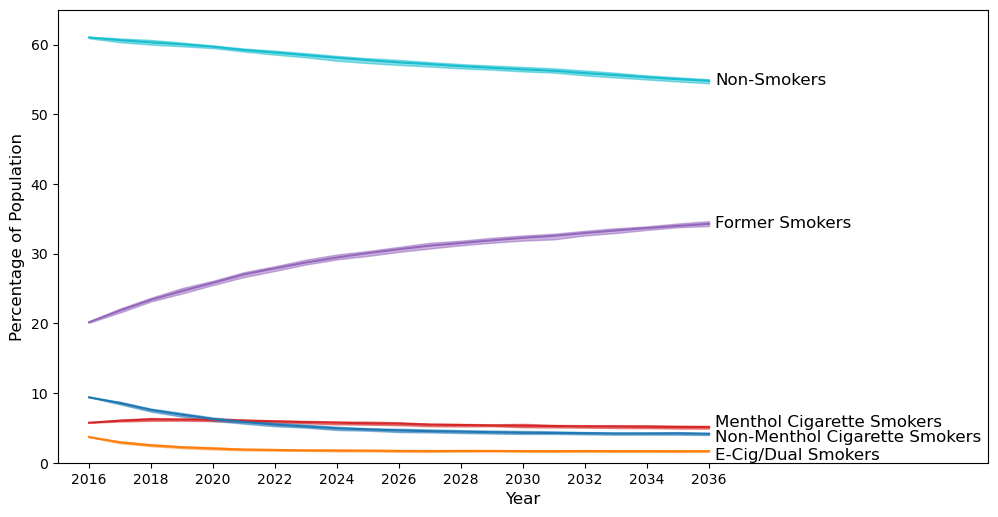

In [38]:

# Smoking groups over time, total population, status quo scenario
# with the smoking states being menthol, nonmenthol, menthol+nonmenthol, ecig/dual, former, nonsmoker
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:cyan',]

opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2037)

to_plot = np.copy(collection_list_options[opt, :, :, :, :, :])
to_plot = to_plot[:,:,:,:,:21] # first 15 years 
# dims:  output #, smoking status, black, pov, year
to_plot = np.sum(to_plot, axis=(2,3)) # combine all demographics
# dims:  output #, smoking status, year; shape (125, 6, 16)
""" 
When summing to get population totals, make sure that the menthol+nonmenthol group
is not summed, because then we will be double counting those smoker groups
"""
sums = np.sum(to_plot[:,[0,1,3,4,5],:], axis=1) # sum over smoking states to get totals
to_plot = to_plot / sums[:, np.newaxis, :] # change from absolute counts to proportion of total
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)
print(mean.shape)
print(lower.shape)
print(upper.shape)

ax.plot(x, mean[0], mycolors[0])
ax.fill_between(x, lower[0], upper[0], color=mycolors[0], alpha=0.5, label='_nolegend_')
ax.text(x[-1] + 0.2,mean[0,-1],f"Menthol Cigarette Smokers", fontsize=12)

ax.plot(x, mean[1], mycolors[1])
ax.fill_between(x, lower[1], upper[1], color=mycolors[1], alpha=0.5, label='_nolegend_')
ax.text(x[-1] + 0.2,mean[1,-1]-1.2,f"Non-Menthol Cigarette Smokers", fontsize=12)

# ax.plot(x, mean[2], mycolors[2])
# ax.fill_between(x, lower[2], upper[2], color=mycolors[2], alpha=0.5, label='_nolegend_')

ax.plot(x, mean[3], mycolors[3])
ax.fill_between(x, lower[3], upper[3], color=mycolors[3], alpha=0.5, label='_nolegend_')
ax.text(x[-1] + 0.2,mean[3,-1] - 1.2,f"E-Cig/Dual Smokers", fontsize=12)

ax.plot(x, mean[4], mycolors[4])
ax.fill_between(x, lower[4], upper[4], color=mycolors[4], alpha=0.5, label='_nolegend_')
ax.text(x[-1] + 0.2,mean[4,-1]-0.5,f"Former Smokers", fontsize=12)

ax.plot(x, mean[5], mycolors[5])
ax.fill_between(x, lower[5], upper[5], color=mycolors[5], alpha=0.5, label='_nolegend_')
ax.text(x[-1] + 0.2,mean[5,-1]-0.5,f"Non-Smokers", fontsize=12)

plt.ylim(0,65)
plt.xlim(x[0]-1, x[-1]+9)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x[::2], fontsize=10, horizontalalignment='center')
# y_tick_nums = np.arange(0,61,10)
# y_tick_labels = [str(x) + "%" for x in y_tick_nums]
# plt.yticks(y_tick_nums, y_tick_labels)
# plt.legend(loc=(0.1,0.5) , labels=[ 
#     f"Menthol Cigarette Smokers",
#     f"Non-Menthol Cigarette Smokers",
#     # f"All Cigarette Smokers",
#     f"E-Cig/Dual Smokers",
#     f"Former Smokers",
#     f"Non-Smokers",
# ])

plt.show()